In [1]:
!nvidia-smi

Tue Dec  3 02:26:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cuda'

## Preparing the data

In [3]:
# unziping the data

import os

zip_file = "aux_data.zip"

if os.path.exists("aux_data"):
  print("File is already unzipped")
else:
  !unzip aux_data.zip
  print("File unzipped")

Streaming output truncated to the last 5000 lines.
  inflating: aux_data/images/with_mask/with_mask_246.jpg  
  inflating: aux_data/images/with_mask/with_mask_252.jpg  
  inflating: aux_data/images/with_mask/with_mask_1181.jpg  
  inflating: aux_data/images/with_mask/with_mask_534.jpg  
  inflating: aux_data/images/with_mask/with_mask_2488.jpg  
  inflating: aux_data/images/with_mask/with_mask_1817.jpg  
  inflating: aux_data/images/with_mask/with_mask_1803.jpg  
  inflating: aux_data/images/with_mask/with_mask_508.jpg  
  inflating: aux_data/images/with_mask/with_mask_1022.jpg  
  inflating: aux_data/images/with_mask/with_mask_497.jpg  
  inflating: aux_data/images/with_mask/with_mask_3635.jpg  
  inflating: aux_data/images/with_mask/with_mask_3153.jpg  
  inflating: aux_data/images/with_mask/with_mask_1744.jpg  
  inflating: aux_data/images/with_mask/with_mask_1750.jpg  
  inflating: aux_data/images/with_mask/with_mask_1988.jpg  
  inflating: aux_data/images/with_mask/with_mask_3147.

### Creating a DataFrame that contains all the images paths and it's emotions

In [4]:
# creating initial dataframe

import pandas as pd
import glob
import os

with_mask_image_path = glob.glob(os.path.join("aux_data/images/with_mask", "*.jpg"))
df = pd.DataFrame({"Images": with_mask_image_path, "Mask": 1})

without_mask_image_path = glob.glob(os.path.join("aux_data/images/without_mask", "*.jpg"))
df_new = pd.DataFrame({"Images": without_mask_image_path, "Mask": 0})
df = pd.concat([df, df_new], ignore_index = True)

In [5]:
df

,Images,Mask
0,aux_data/images/with_mask/with_mask_3406.jpg,1
1,aux_data/images/with_mask/with_mask_3579.jpg,1
2,aux_data/images/with_mask/with_mask_374.jpg,1
3,aux_data/images/with_mask/with_mask_1629.jpg,1
4,aux_data/images/with_mask/with_mask_1749.jpg,1
...,...,...
7548,aux_data/images/without_mask/without_mask_3351...,0
7549,aux_data/images/without_mask/without_mask_93.jpg,0
7550,aux_data/images/without_mask/without_mask_2464...,0
7551,aux_data/images/without_mask/without_mask_1198...,0


In [6]:
df["Mask"].unique(), df["Mask"].value_counts()

(array([1, 0]),
 Mask
 0    3828
 1    3725
 Name: count, dtype: int64)

As 1 represents with mask, and 0 without mask.

### Creating a custom PyTorch dataset with the dataframe used before:

In [7]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from PIL import Image

In [8]:
# a simple subclass of Dataset

class ImageData(Dataset):
  def __init__(self, transformation):
    self.dataframe = df
    self.transform = transformation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index]["Images"]

    image = Image.open(image_path)
    label = self.dataframe.iloc[index]["Mask"]

    if self.transform:
      image = self.transform(image)

    return image, label

In [9]:
# defining transform
transformation = transforms.Compose([transforms.Grayscale(1), transforms.Resize(size = (128, 128)), transforms.ToTensor()])

image_dataset = ImageData(transformation)

In [10]:
image_dataset[0]

(tensor([[[0.4549, 0.4863, 0.5098,  ..., 0.6824, 0.6392, 0.6392],
          [0.4549, 0.4824, 0.5059,  ..., 0.6745, 0.6392, 0.6392],
          [0.4510, 0.4745, 0.5059,  ..., 0.6706, 0.6392, 0.6431],
          ...,
          [0.7608, 0.7569, 0.7529,  ..., 0.3765, 0.2000, 0.2314],
          [0.7686, 0.7725, 0.7725,  ..., 0.4157, 0.2118, 0.2196],
          [0.7725, 0.7765, 0.7765,  ..., 0.4078, 0.2275, 0.2118]]]),
 1)

In [11]:
# creating a dictionary to pass labels into indexes:
index_label_dict = {
    0 : "without mask",
    1 : "with mask"
}

In [12]:
index_label_dict[image_dataset[0][1]]

'with mask'

### Train test separation:

In [13]:
x = []
y = []

for image, label in image_dataset:
  x.append(image)
  y.append(label)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 42)

In [15]:
len(x_train), len(y_train), len(x_test), len(y_test)

(6042, 6042, 1511, 1511)

In [16]:
image_train_dataset = list(zip(x_train, y_train))
image_test_dataset = list(zip(x_test, y_test))

In [17]:
image_train_dataset[0], image_test_dataset[0]

((tensor([[[0.8745, 0.8745, 0.8745,  ..., 0.8588, 0.8588, 0.8588],
           [0.8745, 0.8745, 0.8745,  ..., 0.8588, 0.8588, 0.8588],
           [0.8745, 0.8745, 0.8745,  ..., 0.8588, 0.8588, 0.8588],
           ...,
           [0.8667, 0.8824, 0.8824,  ..., 0.3137, 0.7765, 0.8549],
           [0.8667, 0.8824, 0.8745,  ..., 0.2157, 0.4824, 0.8353],
           [0.8745, 0.8784, 0.8353,  ..., 0.2000, 0.2902, 0.7608]]]),
  1),
 (tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]),
  1))

In [18]:
# creating dataloaders for train and test

image_train_dataloader = DataLoader(image_train_dataset, batch_size = 32, shuffle = True)
image_test_dataloader = DataLoader(image_test_dataset, batch_size = 32, shuffle = False)

In [19]:
next(iter(image_train_dataloader))

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.0510, 0.0510, 0.0510],
           [1.0000, 1.0000, 1.0000,  ..., 0.0510, 0.0510, 0.0471],
           [1.0000, 1.0000, 1.0000,  ..., 0.0471, 0.0431, 0.0431]]],
 
 
         [[[0.7255, 0.7333, 0.7412,  ..., 0.6549, 0.6510, 0.6471],
           [0.7333, 0.7412, 0.7490,  ..., 0.6510, 0.6549, 0.6510],
           [0.7333, 0.7412, 0.7490,  ..., 0.6510, 0.6510, 0.6510],
           ...,
           [0.6392, 0.6235, 0.6510,  ..., 0.5373, 0.5294, 0.5294],
           [0.6353, 0.6275, 0.6510,  ..., 0.5333, 0.5294, 0.5294],
           [0.6235, 0.6353, 0.6510,  ..., 0.5294, 0.5255, 0.5294]]],
 
 
         [[[0.9216, 0.9216, 0.9216,  ..., 0.9373, 0.9373, 0.9373],
           [0.9255, 0.9255, 0.9255,  ..., 0.9373, 0.9373, 0.9373],
           [0.9294

In [20]:
image, label = next(iter(image_train_dataloader))
image.shape, label.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

### Visualizing images:

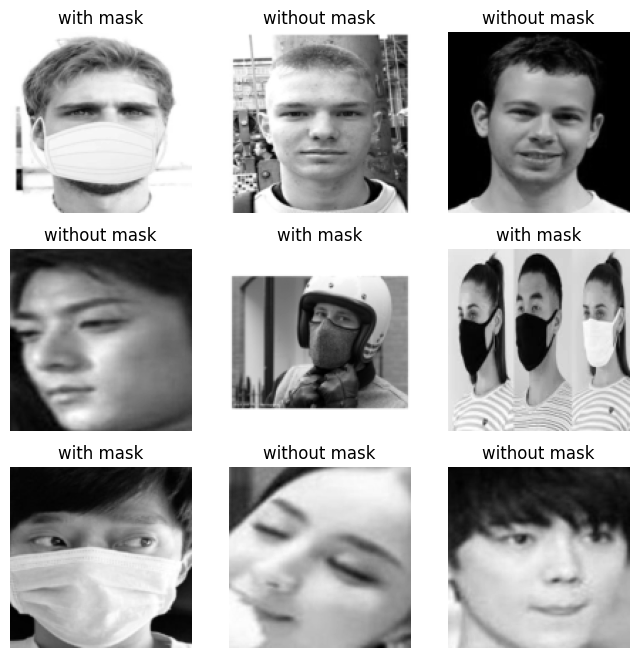

In [21]:
import random
import matplotlib.pyplot as plt

torch.manual_seed(42)

plt.figure(figsize = (8, 8))
for i, (image, label) in enumerate(random.sample(image_train_dataset, k = 9)):

  plt.subplot(3, 3, i+1)

  plt.title(f"{index_label_dict[label]}")
  plt.axis(False)
  plt.imshow(image[0, :, :].squeeze(), cmap = "gray")


## Instantiating the model

#### This model is inspired on the model proposed by the article: Kim,J.H.,Kim,B.G.,Roy,P.P.&Jeong,D.M.Efficient facial expression recognition algorithm based on hierarchical deep neural network structure. IEEE Access 7, 41273–41285 (2019).

In [22]:
from cnn_model import CNNImages
model_cnn = CNNImages(1, 64, 2)

In [23]:
image, label = next(iter(image_train_dataloader))

In [24]:
image.shape

torch.Size([32, 1, 128, 128])

In [25]:
model_cnn(image)

tensor([[-0.0023,  0.0161],
        [ 0.0004,  0.0158],
        [-0.0031,  0.0110],
        [-0.0052,  0.0224],
        [ 0.0009,  0.0244],
        [ 0.0050,  0.0181],
        [-0.0065,  0.0203],
        [ 0.0023,  0.0206],
        [-0.0039,  0.0123],
        [ 0.0021,  0.0183],
        [ 0.0025,  0.0209],
        [-0.0034,  0.0154],
        [ 0.0020,  0.0133],
        [-0.0020,  0.0158],
        [-0.0043,  0.0072],
        [ 0.0006,  0.0198],
        [ 0.0043,  0.0196],
        [ 0.0002,  0.0162],
        [-0.0040,  0.0087],
        [-0.0027,  0.0181],
        [ 0.0064,  0.0143],
        [-0.0067,  0.0099],
        [-0.0043,  0.0104],
        [ 0.0061,  0.0281],
        [ 0.0011,  0.0153],
        [ 0.0043,  0.0162],
        [-0.0009,  0.0179],
        [ 0.0012,  0.0163],
        [-0.0085,  0.0165],
        [ 0.0011,  0.0170],
        [-0.0012,  0.0150],
        [ 0.0016,  0.0127]], grad_fn=<AddmmBackward0>)

## Testing and Training the model

### Defining optimizer, loss and metrics of evaluation

In [26]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.8 MB/s eta 0:00:00


In [28]:
from torchmetrics import Accuracy
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_cnn.parameters(), lr = 0.1, weight_decay=1e-5)
accuracy_fn = Accuracy(task = "multiclass", num_classes = 2)

### Train and test loop

In [29]:
import torchmetrics
from tqdm.auto import trange

def train_test_loop(model : nn.Module, train_dataloader : torch.utils.data, test_dataloader : torch.utils.data, loss_fn : nn.Module, optimizer : torch.optim.Optimizer, accuracy_fn : torchmetrics, device : torch.device = device):
  model = model.to(device)
  accuracy_fn = accuracy_fn.to(device)

  for epoch in trange(20):
    # train

    loss_train, accuracy_train = 0, 0
    model.train()
    for image, label in train_dataloader:
      image, label = image.to(device), label.to(device)

      y_pred = model(image)
      loss = loss_fn(y_pred, label)
      loss_train += loss
      accuracy_train += accuracy_fn(y_pred, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_train /= len(train_dataloader)
    accuracy_train /= len(train_dataloader)

    # test

    loss_test, accuracy_test = 0, 0
    model.eval()
    with torch.inference_mode():
      for image, label in test_dataloader:
        image, label = image.to(device), label.to(device)

        y_pred = model(image)
        loss_test += loss_fn(y_pred, label)
        accuracy_test += accuracy_fn(y_pred, label)

      loss_test /= len(test_dataloader)
      accuracy_test /= len(test_dataloader)

    print(f"Train loss: {loss_train} | Train accuracy: {accuracy_train} | Test loss: {loss_test} | Test accuracy: {accuracy_test}")


In [30]:
torch.manual_seed(42)

train_test_loop(model_cnn, image_train_dataloader, image_test_dataloader, loss_fn, optimizer, accuracy_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.6570917367935181 | Train accuracy: 0.5973875522613525 | Test loss: 0.6661585569381714 | Test accuracy: 0.5835193395614624
Train loss: 0.5868726968765259 | Train accuracy: 0.6841294765472412 | Test loss: 0.768673837184906 | Test accuracy: 0.5525484085083008
Train loss: 0.5077236890792847 | Train accuracy: 0.7488934397697449 | Test loss: 0.41595885157585144 | Test accuracy: 0.8117560148239136
Train loss: 0.39257746934890747 | Train accuracy: 0.8180962204933167 | Test loss: 0.3353498876094818 | Test accuracy: 0.8475632667541504
Train loss: 0.29615285992622375 | Train accuracy: 0.8707900643348694 | Test loss: 0.31972724199295044 | Test accuracy: 0.8582589626312256
Train loss: 0.2329098880290985 | Train accuracy: 0.9093533158302307 | Test loss: 0.27796274423599243 | Test accuracy: 0.8824405074119568
Train loss: 0.22266890108585358 | Train accuracy: 0.9073691964149475 | Test loss: 0.30923014879226685 | Test accuracy: 0.8859747648239136
Train loss: 0.1460830122232437 | Train acc

## Confusion Matrix

In [31]:
# making predictions

from tqdm.auto import tqdm

y_pred_list = []

model_cnn.eval()
with torch.inference_mode():
  for image, label in tqdm(image_test_dataloader):
    image, label = image.to(device), label.to(device)

    y_pred = model_cnn(image)
    y_pred_label = torch.softmax(y_pred, dim = 1).argmax(dim = 1)
    y_pred_list.append(y_pred_label.cpu())

y_pred_tensor = torch.cat(y_pred_list)
y_pred_tensor

  0%|          | 0/48 [00:00<?, ?it/s]

tensor([1, 1, 1,  ..., 1, 1, 1])

In [32]:
# picking all the targets

import numpy as np

targets = []

for i in image_test_dataset:
  targets.append(i[1])

targets = np.array(targets)

In [33]:
targets

array([1, 1, 1, ..., 1, 0, 0])

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

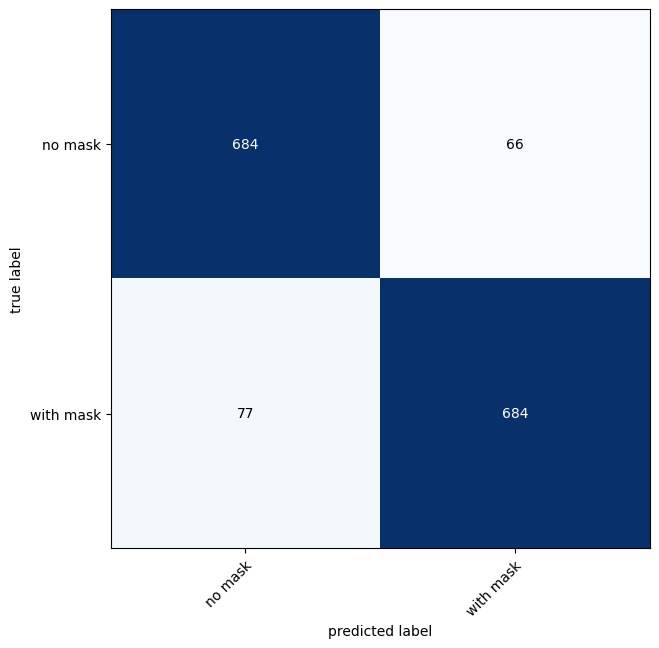

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix = ConfusionMatrix(num_classes = 2, task = "multiclass")
confusion_matrix_tensor = confusion_matrix(preds = y_pred_tensor, target = torch.from_numpy(targets))

plot_confusion_matrix(conf_mat = confusion_matrix_tensor.numpy(), class_names = ["no mask", "with mask"], figsize = (10, 7))

Which is really according to the accuracy obtained.

## Saving the model:

In [35]:
torch.save(obj = model_cnn.state_dict(), f = "aux_data/cnn_model.pth")